# GAN with Mixture Model for Tabular Data

## Key Insight
Standard GANs fail on tabular data because neural networks with smooth activations cannot model **point masses** (delta functions). The Adult dataset has:
- **capital-gain**: 91% exactly 0
- **capital-loss**: 95% exactly 0  
- **hours-per-week**: 47% exactly 40

## Solution: Mixture Models
Instead of hoping the network learns these spikes, we explicitly model them:
```
P(x) = p_special * delta(special_value) + (1-p_special) * P_continuous(x)
```

The generator outputs:
1. `is_special` probability (sigmoid)
2. `continuous_value` (only used when not special)

At generation time, we SAMPLE from the binary indicator to produce EXACT special values.

## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
import os

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Using device: cpu


## 2. Load Data

In [2]:
# Load the Adult dataset
data, meta = arff.loadarff('../data/adult.arff')
df = pd.DataFrame(data)

# Decode byte strings
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset shape: (32561, 15)

Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


## 3. Analyze Special Values

Let's confirm the point masses we need to model explicitly.

In [3]:
# Analyze zero-inflation and peak-inflation
print("=" * 60)
print("SPECIAL VALUE ANALYSIS")
print("=" * 60)

# Zero-inflated features
for col in ['capital-gain', 'capital-loss']:
    zero_pct = (df[col] == 0).mean() * 100
    print(f"\n{col}:")
    print(f"  Zero percentage: {zero_pct:.1f}%")
    print(f"  Non-zero range: [{df[df[col] > 0][col].min()}, {df[df[col] > 0][col].max()}]")

# Peak-inflated feature
col = 'hours-per-week'
peak_val = 40
peak_pct = (df[col] == peak_val).mean() * 100
print(f"\n{col}:")
print(f"  Peak at {peak_val}: {peak_pct:.1f}%")
print(f"  Full range: [{df[col].min()}, {df[col].max()}]")

# Education-num distribution (should be categorical)
print(f"\neducation-num unique values: {sorted(df['education-num'].unique())}")
print(f"Top 5 values:")
print(df['education-num'].value_counts().head())

SPECIAL VALUE ANALYSIS

capital-gain:
  Zero percentage: 91.7%
  Non-zero range: [114.0, 99999.0]

capital-loss:
  Zero percentage: 95.3%
  Non-zero range: [155.0, 4356.0]

hours-per-week:
  Peak at 40: 46.7%
  Full range: [1.0, 99.0]

education-num unique values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0)]
Top 5 values:
education-num
9.0     10501
10.0     7291
13.0     5355
14.0     1723
11.0     1382
Name: count, dtype: int64


## 4. Feature Configuration

We categorize features by how they should be modeled:

In [4]:
# Feature categorization
ZERO_INFLATED_COLS = ['capital-gain', 'capital-loss']  # ~90%+ zeros
PEAK_INFLATED_COLS = ['hours-per-week']  # 47% at value 40
PEAK_VALUES = {'hours-per-week': 40}

# Regular continuous (no special handling needed)
REGULAR_CONTINUOUS_COLS = ['age', 'fnlwgt']

# Treat education-num as categorical (discrete values 1-16)
DISCRETE_AS_CATEGORICAL = ['education-num']

# Standard categorical
CATEGORICAL_COLS = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']

TARGET_COL = 'income'

print("Feature Configuration:")
print(f"  Zero-inflated: {ZERO_INFLATED_COLS}")
print(f"  Peak-inflated: {PEAK_INFLATED_COLS}")
print(f"  Regular continuous: {REGULAR_CONTINUOUS_COLS}")
print(f"  Discrete as categorical: {DISCRETE_AS_CATEGORICAL}")
print(f"  Categorical: {CATEGORICAL_COLS}")

Feature Configuration:
  Zero-inflated: ['capital-gain', 'capital-loss']
  Peak-inflated: ['hours-per-week']
  Regular continuous: ['age', 'fnlwgt']
  Discrete as categorical: ['education-num']
  Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## 5. Preprocessor with Special Value Handling

In [5]:
class MixturePreprocessor:
    """
    Preprocessor that handles:
    - Zero-inflated features: stores zero proportion, scales non-zeros
    - Peak-inflated features: stores peak proportion, scales non-peaks
    - Discrete-as-categorical: one-hot encoding
    - Regular continuous: MinMax scaling
    - Categorical: one-hot encoding
    """
    
    def __init__(self):
        self.scalers = {}  # MinMax scalers for continuous parts
        self.zero_proportions = {}  # Proportion of zeros
        self.peak_proportions = {}  # Proportion of peak values
        self.category_mappings = {}  # Category to index
        self.category_dims = {}  # Number of categories per feature
        self.label_encoder = LabelEncoder()
        self.mode_values = {}  # For imputation
        
        # Feature info for reconstruction
        self.feature_info = []  # List of (name, type, dim) tuples
        
    def fit(self, df):
        df = df.copy()
        
        # Impute missing categorical values
        for col in CATEGORICAL_COLS:
            valid = df[df[col] != '?'][col]
            if len(valid) > 0:
                self.mode_values[col] = valid.mode()[0]
                df[col] = df[col].replace('?', self.mode_values[col])
        
        # Process zero-inflated features
        for col in ZERO_INFLATED_COLS:
            self.zero_proportions[col] = (df[col] == 0).mean()
            # Fit scaler on non-zero values only
            non_zero = df[df[col] > 0][col].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            scaler.fit(non_zero)
            self.scalers[col] = scaler
            # Output: is_zero (1), value (1) = 2 dims
            self.feature_info.append((col, 'zero_inflated', 2))
        
        # Process peak-inflated features
        for col in PEAK_INFLATED_COLS:
            peak_val = PEAK_VALUES[col]
            self.peak_proportions[col] = (df[col] == peak_val).mean()
            # Fit scaler on non-peak values
            non_peak = df[df[col] != peak_val][col].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            scaler.fit(non_peak)
            self.scalers[col] = scaler
            # Output: is_peak (1), value (1) = 2 dims
            self.feature_info.append((col, 'peak_inflated', 2))
        
        # Process regular continuous
        for col in REGULAR_CONTINUOUS_COLS:
            scaler = MinMaxScaler()
            scaler.fit(df[col].values.reshape(-1, 1))
            self.scalers[col] = scaler
            # Output: value (1) = 1 dim
            self.feature_info.append((col, 'continuous', 1))
        
        # Process discrete-as-categorical (education-num)
        for col in DISCRETE_AS_CATEGORICAL:
            unique_vals = sorted(df[col].unique())
            self.category_mappings[col] = {v: i for i, v in enumerate(unique_vals)}
            self.category_dims[col] = len(unique_vals)
            self.feature_info.append((col, 'categorical', len(unique_vals)))
        
        # Process categorical features
        for col in CATEGORICAL_COLS:
            unique_vals = sorted(df[col].unique())
            self.category_mappings[col] = {v: i for i, v in enumerate(unique_vals)}
            self.category_dims[col] = len(unique_vals)
            self.feature_info.append((col, 'categorical', len(unique_vals)))
        
        # Fit label encoder
        self.label_encoder.fit(df[TARGET_COL])
        
        return self
    
    def transform(self, df):
        """Transform data to model input format."""
        df = df.copy()
        
        # Impute missing
        for col, mode in self.mode_values.items():
            df[col] = df[col].replace('?', mode)
        
        arrays = []
        
        # Zero-inflated features
        for col in ZERO_INFLATED_COLS:
            is_zero = (df[col] == 0).astype(np.float32).values.reshape(-1, 1)
            # Scale non-zeros, zeros get 0
            values = df[col].values.copy().astype(np.float32)
            non_zero_mask = values > 0
            if non_zero_mask.any():
                values[non_zero_mask] = self.scalers[col].transform(
                    values[non_zero_mask].reshape(-1, 1)
                ).flatten()
            values[~non_zero_mask] = 0
            arrays.append(is_zero)
            arrays.append(values.reshape(-1, 1))
        
        # Peak-inflated features
        for col in PEAK_INFLATED_COLS:
            peak_val = PEAK_VALUES[col]
            is_peak = (df[col] == peak_val).astype(np.float32).values.reshape(-1, 1)
            # Scale non-peaks
            values = df[col].values.copy().astype(np.float32)
            non_peak_mask = values != peak_val
            if non_peak_mask.any():
                values[non_peak_mask] = self.scalers[col].transform(
                    values[non_peak_mask].reshape(-1, 1)
                ).flatten()
            values[~non_peak_mask] = 0.5  # Placeholder for peak values
            arrays.append(is_peak)
            arrays.append(values.reshape(-1, 1))
        
        # Regular continuous
        for col in REGULAR_CONTINUOUS_COLS:
            scaled = self.scalers[col].transform(df[col].values.reshape(-1, 1))
            arrays.append(scaled.astype(np.float32))
        
        # Discrete-as-categorical and categorical
        for col in DISCRETE_AS_CATEGORICAL + CATEGORICAL_COLS:
            n_cat = self.category_dims[col]
            onehot = np.zeros((len(df), n_cat), dtype=np.float32)
            for i, val in enumerate(df[col]):
                if val in self.category_mappings[col]:
                    onehot[i, self.category_mappings[col][val]] = 1
            arrays.append(onehot)
        
        X = np.hstack(arrays)
        y = self.label_encoder.transform(df[TARGET_COL])
        
        return X, y
    
    def get_output_dim(self):
        return sum(info[2] for info in self.feature_info)
    
    def get_feature_slices(self):
        """Get start/end indices for each feature in the output."""
        slices = {}
        pos = 0
        for name, ftype, dim in self.feature_info:
            slices[name] = (pos, pos + dim, ftype)
            pos += dim
        return slices
    
    def print_structure(self):
        print("\nPreprocessor Structure:")
        print("-" * 50)
        pos = 0
        for name, ftype, dim in self.feature_info:
            print(f"  [{pos:3d}-{pos+dim-1:3d}] {name} ({ftype}, dim={dim})")
            pos += dim
        print(f"\nTotal dimensions: {self.get_output_dim()}")

In [6]:
# Test preprocessor
preprocessor = MixturePreprocessor()
preprocessor.fit(df)
preprocessor.print_structure()

print("\nSpecial value proportions (from training data):")
for col, prop in preprocessor.zero_proportions.items():
    print(f"  {col} zeros: {prop:.1%}")
for col, prop in preprocessor.peak_proportions.items():
    print(f"  {col} peaks: {prop:.1%}")


Preprocessor Structure:
--------------------------------------------------
  [  0-  1] capital-gain (zero_inflated, dim=2)
  [  2-  3] capital-loss (zero_inflated, dim=2)
  [  4-  5] hours-per-week (peak_inflated, dim=2)
  [  6-  6] age (continuous, dim=1)
  [  7-  7] fnlwgt (continuous, dim=1)
  [  8- 23] education-num (categorical, dim=16)
  [ 24- 31] workclass (categorical, dim=8)
  [ 32- 47] education (categorical, dim=16)
  [ 48- 54] marital-status (categorical, dim=7)
  [ 55- 68] occupation (categorical, dim=14)
  [ 69- 74] relationship (categorical, dim=6)
  [ 75- 79] race (categorical, dim=5)
  [ 80- 81] sex (categorical, dim=2)
  [ 82-122] native-country (categorical, dim=41)

Total dimensions: 123

Special value proportions (from training data):
  capital-gain zeros: 91.7%
  capital-loss zeros: 95.3%
  hours-per-week peaks: 46.7%


## 6. Data Preparation

In [7]:
def prepare_data(df, seed=42, test_size=0.2):
    """Prepare train/test data with stratified split."""
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=seed, stratify=df[TARGET_COL]
    )
    
    preprocessor = MixturePreprocessor()
    preprocessor.fit(train_df)
    
    X_train, y_train = preprocessor.transform(train_df)
    X_test, y_test = preprocessor.transform(test_df)
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Label distribution: {np.bincount(y_train) / len(y_train)}")
    
    return X_train, X_test, y_train, y_test, preprocessor

# Test
X_train, X_test, y_train, y_test, prep = prepare_data(df, seed=42)
prep.print_structure()

Train: (26048, 123), Test: (6513, 123)
Label distribution: [0.75917537 0.24082463]

Preprocessor Structure:
--------------------------------------------------
  [  0-  1] capital-gain (zero_inflated, dim=2)
  [  2-  3] capital-loss (zero_inflated, dim=2)
  [  4-  5] hours-per-week (peak_inflated, dim=2)
  [  6-  6] age (continuous, dim=1)
  [  7-  7] fnlwgt (continuous, dim=1)
  [  8- 23] education-num (categorical, dim=16)
  [ 24- 31] workclass (categorical, dim=8)
  [ 32- 47] education (categorical, dim=16)
  [ 48- 54] marital-status (categorical, dim=7)
  [ 55- 68] occupation (categorical, dim=14)
  [ 69- 74] relationship (categorical, dim=6)
  [ 75- 79] race (categorical, dim=5)
  [ 80- 81] sex (categorical, dim=2)
  [ 82-122] native-country (categorical, dim=41)

Total dimensions: 123


## 7. Generator with Mixture Model Outputs

The key innovation: separate output heads for special vs continuous values.

In [8]:
class MixtureGenerator(nn.Module):
    """
    Generator with explicit mixture model outputs for:
    - Zero-inflated features: (is_zero_prob, value_if_nonzero)
    - Peak-inflated features: (is_peak_prob, value_if_not_peak)
    - Regular continuous: (value)
    - Categorical: (softmax over categories)
    """
    
    def __init__(self, latent_dim, preprocessor, hidden_dim=256, temperature=0.5):
        super().__init__()
        self.latent_dim = latent_dim
        self.preprocessor = preprocessor
        self.temperature = temperature
        self.feature_info = preprocessor.feature_info
        self.output_dim = preprocessor.get_output_dim()
        
        # Main network
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim * 2, self.output_dim)
        )
    
    def forward(self, z, hard=False):
        """
        Generate data.
        
        Args:
            z: Latent noise
            hard: If True, use hard sampling (for generation). 
                  If False, use soft outputs (for training).
        """
        x = self.main(z)
        
        outputs = []
        pos = 0
        
        for name, ftype, dim in self.feature_info:
            if ftype == 'zero_inflated':
                # Output: is_zero (sigmoid), value (sigmoid)
                is_zero_logit = x[:, pos]
                value_logit = x[:, pos + 1]
                
                is_zero_prob = torch.sigmoid(is_zero_logit)
                value = torch.sigmoid(value_logit)
                
                if hard or not self.training:
                    # Hard sampling: actually set zeros
                    is_zero = (is_zero_prob > 0.5).float()
                    # Value is 0 when is_zero=1, otherwise the continuous value
                    final_value = (1 - is_zero) * value
                    outputs.append(is_zero.unsqueeze(1))
                    outputs.append(final_value.unsqueeze(1))
                else:
                    # Soft output for training (allows gradients)
                    outputs.append(is_zero_prob.unsqueeze(1))
                    outputs.append(value.unsqueeze(1))
                
                pos += 2
                
            elif ftype == 'peak_inflated':
                # Output: is_peak (sigmoid), value (sigmoid)
                is_peak_logit = x[:, pos]
                value_logit = x[:, pos + 1]
                
                is_peak_prob = torch.sigmoid(is_peak_logit)
                value = torch.sigmoid(value_logit)
                
                if hard or not self.training:
                    is_peak = (is_peak_prob > 0.5).float()
                    # For peaks, we need to output the scaled peak value
                    # Peak value (40) gets mapped to ~0.4 in MinMax
                    peak_scaled = 0.5  # Placeholder, actual inverse transform handles this
                    final_value = is_peak * peak_scaled + (1 - is_peak) * value
                    outputs.append(is_peak.unsqueeze(1))
                    outputs.append(final_value.unsqueeze(1))
                else:
                    outputs.append(is_peak_prob.unsqueeze(1))
                    outputs.append(value.unsqueeze(1))
                
                pos += 2
                
            elif ftype == 'continuous':
                # Regular continuous: just sigmoid
                value = torch.sigmoid(x[:, pos])
                outputs.append(value.unsqueeze(1))
                pos += 1
                
            elif ftype == 'categorical':
                # Categorical: Gumbel-softmax
                logits = x[:, pos:pos + dim]
                
                if hard or not self.training:
                    # Hard one-hot
                    idx = logits.argmax(dim=-1, keepdim=True)
                    onehot = torch.zeros_like(logits).scatter_(-1, idx, 1.0)
                else:
                    # Gumbel-softmax with straight-through
                    gumbels = -torch.log(-torch.log(torch.rand_like(logits) + 1e-20) + 1e-20)
                    y_soft = F.softmax((logits + gumbels) / self.temperature, dim=-1)
                    idx = y_soft.argmax(dim=-1, keepdim=True)
                    y_hard = torch.zeros_like(logits).scatter_(-1, idx, 1.0)
                    onehot = y_hard - y_soft.detach() + y_soft
                
                outputs.append(onehot)
                pos += dim
        
        return torch.cat(outputs, dim=1)
    
    def generate(self, n_samples):
        """Generate samples with hard decisions."""
        self.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim, device=next(self.parameters()).device)
            return self.forward(z, hard=True)


class Discriminator(nn.Module):
    """Standard discriminator with dropout for regularization."""
    
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.main(x)

## 8. Loss Functions

Key: **Proportion matching loss** to ensure correct special value ratios.

In [9]:
def gradient_penalty(discriminator, real_data, fake_data, device):
    """WGAN-GP gradient penalty."""
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    
    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    d_out = discriminator(interpolated)
    
    grads = torch.autograd.grad(
        outputs=d_out,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_out),
        create_graph=True,
        retain_graph=True
    )[0]
    
    grads = grads.view(batch_size, -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()


def proportion_matching_loss(fake_data, preprocessor):
    """
    Loss to match proportions of special values.
    
    For zero-inflated: match proportion of zeros
    For peak-inflated: match proportion of peaks
    """
    loss = 0.0
    pos = 0
    
    for name, ftype, dim in preprocessor.feature_info:
        if ftype == 'zero_inflated':
            # is_zero is at position pos
            is_zero_prob = fake_data[:, pos]
            target_prop = preprocessor.zero_proportions[name]
            actual_prop = is_zero_prob.mean()
            loss += (actual_prop - target_prop) ** 2
            pos += 2
            
        elif ftype == 'peak_inflated':
            is_peak_prob = fake_data[:, pos]
            target_prop = preprocessor.peak_proportions[name]
            actual_prop = is_peak_prob.mean()
            loss += (actual_prop - target_prop) ** 2
            pos += 2
            
        elif ftype == 'continuous':
            pos += 1
        elif ftype == 'categorical':
            pos += dim
    
    return loss


def categorical_frequency_loss(fake_data, real_data, preprocessor):
    """
    Loss to match categorical frequency distributions.
    """
    loss = 0.0
    pos = 0
    
    for name, ftype, dim in preprocessor.feature_info:
        if ftype == 'categorical':
            # Get category probabilities
            fake_cat = fake_data[:, pos:pos + dim]
            real_cat = real_data[:, pos:pos + dim]
            
            # Compare mean frequencies
            fake_freq = fake_cat.mean(dim=0)
            real_freq = real_cat.mean(dim=0)
            
            loss += F.mse_loss(fake_freq, real_freq)
            pos += dim
        elif ftype in ['zero_inflated', 'peak_inflated']:
            pos += 2
        elif ftype == 'continuous':
            pos += 1
    
    return loss

## 9. Training Function

In [10]:
def train_gan(X_train, preprocessor, 
              latent_dim=128, hidden_dim=256,
              batch_size=256, epochs=300,
              lr_g=0.0002, lr_d=0.0001,
              n_critic=5, lambda_gp=10,
              lambda_prop=1.0, lambda_cat=0.1,
              dropout=0.3, seed=42):
    """
    Train WGAN-GP with mixture model generator.
    
    Args:
        lambda_prop: Weight for proportion matching loss
        lambda_cat: Weight for categorical frequency loss
    """
    set_seed(seed)
    
    data_dim = preprocessor.get_output_dim()
    
    generator = MixtureGenerator(
        latent_dim=latent_dim,
        preprocessor=preprocessor,
        hidden_dim=hidden_dim
    ).to(device)
    
    discriminator = Discriminator(
        input_dim=data_dim,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    dataset = TensorDataset(torch.FloatTensor(X_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    g_losses = []
    d_losses = []
    prop_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_prop_loss = 0
        n_batches = 0
        
        for batch_idx, (real_data,) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)
            
            # ========== Train Discriminator ==========
            for _ in range(n_critic):
                optimizer_d.zero_grad()
                
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z, hard=False)
                
                d_real = discriminator(real_data)
                d_fake = discriminator(fake_data.detach())
                
                gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device)
                d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
                
                d_loss.backward()
                optimizer_d.step()
            
            # ========== Train Generator ==========
            optimizer_g.zero_grad()
            
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z, hard=False)
            d_fake = discriminator(fake_data)
            
            # WGAN loss
            g_loss_wgan = -d_fake.mean()
            
            # Proportion matching loss (critical!)
            prop_loss = proportion_matching_loss(fake_data, preprocessor)
            
            # Categorical frequency loss
            cat_loss = categorical_frequency_loss(fake_data, real_data, preprocessor)
            
            # Total generator loss
            g_loss = g_loss_wgan + lambda_prop * prop_loss + lambda_cat * cat_loss
            
            g_loss.backward()
            optimizer_g.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss_wgan.item()
            epoch_prop_loss += prop_loss.item()
            n_batches += 1
        
        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / n_batches)
        prop_losses.append(epoch_prop_loss / n_batches)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D: {d_losses[-1]:.4f} G: {g_losses[-1]:.4f} Prop: {prop_losses[-1]:.6f}")
    
    return generator, g_losses, d_losses, prop_losses

## 10. Data Generation with Proper Special Value Handling

In [11]:
def generate_synthetic_data(generator, n_samples, preprocessor):
    """
    Generate synthetic data with proper special value handling.
    
    Key: Sample from binary indicators to produce EXACT special values.
    """
    generator.eval()
    device = next(generator.parameters()).device
    
    with torch.no_grad():
        z = torch.randn(n_samples, generator.latent_dim, device=device)
        
        # Get raw outputs (with soft probabilities)
        x = generator.main(z)
        
        outputs = []
        pos = 0
        
        for name, ftype, dim in preprocessor.feature_info:
            if ftype == 'zero_inflated':
                is_zero_logit = x[:, pos]
                value_logit = x[:, pos + 1]
                
                is_zero_prob = torch.sigmoid(is_zero_logit)
                value = torch.sigmoid(value_logit)
                
                # SAMPLE from Bernoulli for hard zeros
                is_zero = (torch.rand_like(is_zero_prob) < is_zero_prob).float()
                
                # Value is EXACTLY 0 when is_zero=1
                final_value = (1 - is_zero) * value
                
                outputs.append(is_zero.unsqueeze(1))
                outputs.append(final_value.unsqueeze(1))
                pos += 2
                
            elif ftype == 'peak_inflated':
                is_peak_logit = x[:, pos]
                value_logit = x[:, pos + 1]
                
                is_peak_prob = torch.sigmoid(is_peak_logit)
                value = torch.sigmoid(value_logit)
                
                # SAMPLE from Bernoulli for hard peaks
                is_peak = (torch.rand_like(is_peak_prob) < is_peak_prob).float()
                
                # When is_peak=1, output the scaled peak value
                # For hours-per-week: peak=40, range=[1,99], so scaled = (40-1)/(99-1) ≈ 0.398
                peak_scaled = torch.full_like(value, 0.398)
                final_value = is_peak * peak_scaled + (1 - is_peak) * value
                
                outputs.append(is_peak.unsqueeze(1))
                outputs.append(final_value.unsqueeze(1))
                pos += 2
                
            elif ftype == 'continuous':
                value = torch.sigmoid(x[:, pos])
                outputs.append(value.unsqueeze(1))
                pos += 1
                
            elif ftype == 'categorical':
                logits = x[:, pos:pos + dim]
                # Hard one-hot
                idx = logits.argmax(dim=-1, keepdim=True)
                onehot = torch.zeros_like(logits).scatter_(-1, idx, 1.0)
                outputs.append(onehot)
                pos += dim
        
        synthetic = torch.cat(outputs, dim=1)
    
    return synthetic.cpu().numpy()

## 11. Evaluation Metrics

In [12]:
def compute_detection_metric(X_real, X_synthetic, n_folds=4, seed=42):
    """Detection metric: RF AUC for distinguishing real vs synthetic."""
    y_real = np.zeros(len(X_real))
    y_synthetic = np.ones(len(X_synthetic))
    
    X = np.vstack([X_real, X_synthetic])
    y = np.concatenate([y_real, y_synthetic])
    
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    aucs = []
    
    for train_idx, test_idx in kfold.split(X, y):
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
        rf.fit(X[train_idx], y[train_idx])
        proba = rf.predict_proba(X[test_idx])[:, 1]
        aucs.append(roc_auc_score(y[test_idx], proba))
    
    return np.mean(aucs), np.std(aucs)


def compute_efficacy_metric(X_train_real, y_train_real, X_synthetic, y_synthetic,
                           X_test, y_test, seed=42):
    """Efficacy: AUC ratio of synthetic vs real trained model."""
    # Train on real
    rf_real = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_real.fit(X_train_real, y_train_real)
    auc_real = roc_auc_score(y_test, rf_real.predict_proba(X_test)[:, 1])
    
    # Train on synthetic
    rf_synth = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_synth.fit(X_synthetic, y_synthetic)
    auc_synth = roc_auc_score(y_test, rf_synth.predict_proba(X_test)[:, 1])
    
    return auc_synth / auc_real, auc_real, auc_synth

## 12. Visualization

In [13]:
def plot_losses(g_losses, d_losses, prop_losses=None, title="Training Losses", save_path=None):
    fig, axes = plt.subplots(1, 2 if prop_losses else 1, figsize=(12 if prop_losses else 8, 4))
    
    if prop_losses:
        ax1, ax2 = axes
    else:
        ax1 = axes
    
    ax1.plot(g_losses, label='Generator', alpha=0.8)
    ax1.plot(d_losses, label='Discriminator', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('GAN Losses')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if prop_losses:
        ax2.plot(prop_losses, label='Proportion Loss', color='green', alpha=0.8)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Proportion Matching Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


def plot_special_values(X_real, X_synthetic, preprocessor, title="Special Values", save_path=None):
    """Plot comparison of special value distributions."""
    special_features = []
    pos = 0
    
    for name, ftype, dim in preprocessor.feature_info:
        if ftype in ['zero_inflated', 'peak_inflated']:
            special_features.append((name, ftype, pos))
        pos += dim
    
    n_features = len(special_features)
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
    if n_features == 1:
        axes = [axes]
    
    for ax, (name, ftype, pos) in zip(axes, special_features):
        if ftype == 'zero_inflated':
            real_is_special = X_real[:, pos]
            synth_is_special = X_synthetic[:, pos]
            special_name = 'zeros'
            target = preprocessor.zero_proportions[name]
        else:
            real_is_special = X_real[:, pos]
            synth_is_special = X_synthetic[:, pos]
            special_name = 'peaks'
            target = preprocessor.peak_proportions[name]
        
        real_prop = real_is_special.mean()
        synth_prop = synth_is_special.mean()
        
        bars = ax.bar(['Real', 'Synthetic', 'Target'], 
                      [real_prop, synth_prop, target],
                      color=['blue', 'orange', 'green'], alpha=0.7)
        ax.set_ylabel(f'Proportion of {special_name}')
        ax.set_title(f'{name}\n(Real: {real_prop:.1%}, Synth: {synth_prop:.1%}, Target: {target:.1%})')
        ax.set_ylim(0, 1)
        
        # Add value labels
        for bar, val in zip(bars, [real_prop, synth_prop, target]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.1%}', ha='center', va='bottom')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


def plot_continuous_distributions(X_real, X_synthetic, preprocessor, title="Distributions", save_path=None):
    """Plot continuous feature distributions."""
    # Find continuous features
    cont_features = []
    pos = 0
    for name, ftype, dim in preprocessor.feature_info:
        if ftype == 'continuous':
            cont_features.append((name, pos))
        elif ftype in ['zero_inflated', 'peak_inflated']:
            # Also include the value part (not the indicator)
            cont_features.append((name + '_value', pos + 1))
        pos += dim
    
    n_features = len(cont_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.array(axes).flatten()
    
    for i, (name, pos) in enumerate(cont_features):
        ax = axes[i]
        ax.hist(X_real[:, pos], bins=30, alpha=0.5, label='Real', density=True)
        ax.hist(X_synthetic[:, pos], bins=30, alpha=0.5, label='Synthetic', density=True)
        ax.set_title(name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused axes
    for j in range(len(cont_features), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

## 13. Configuration

In [14]:
# Hyperparameters
SEEDS = [42]
LATENT_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 256
EPOCHS = 300
LR_G = 0.0002
LR_D = 0.0001  # TTUR
N_CRITIC = 5
LAMBDA_GP = 10
LAMBDA_PROP = 1.0  # Proportion matching loss weight
LAMBDA_CAT = 0.1   # Categorical frequency loss weight
DROPOUT = 0.3

# Create output directory
OUTPUT_DIR = '../outputs/gan_fixed'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 60)
print("MIXTURE MODEL GAN CONFIGURATION")
print("=" * 60)
print(f"Latent dim: {LATENT_DIM}")
print(f"Hidden dim: {HIDDEN_DIM}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"LR_G: {LR_G}, LR_D: {LR_D}")
print(f"N_CRITIC: {N_CRITIC}")
print(f"Lambda GP: {LAMBDA_GP}")
print(f"Lambda Proportion: {LAMBDA_PROP}")
print(f"Lambda Categorical: {LAMBDA_CAT}")
print(f"Dropout: {DROPOUT}")
print("=" * 60)

MIXTURE MODEL GAN CONFIGURATION
Latent dim: 128
Hidden dim: 256
Batch size: 256
Epochs: 300
LR_G: 0.0002, LR_D: 0.0001
N_CRITIC: 5
Lambda GP: 10
Lambda Proportion: 1.0
Lambda Categorical: 0.1
Dropout: 0.3


## 14. Training and Evaluation

In [15]:
# Run experiment
seed = SEEDS[0]
print(f"\n{'='*60}")
print(f"Running Mixture Model GAN with seed {seed}")
print(f"{'='*60}")

# Prepare data
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, seed=seed)
preprocessor.print_structure()

# Train
generator, g_losses, d_losses, prop_losses = train_gan(
    X_train, preprocessor,
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr_g=LR_G,
    lr_d=LR_D,
    n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP,
    lambda_prop=LAMBDA_PROP,
    lambda_cat=LAMBDA_CAT,
    dropout=DROPOUT,
    seed=seed
)


Running Mixture Model GAN with seed 42
Train: (26048, 123), Test: (6513, 123)
Label distribution: [0.75917537 0.24082463]

Preprocessor Structure:
--------------------------------------------------
  [  0-  1] capital-gain (zero_inflated, dim=2)
  [  2-  3] capital-loss (zero_inflated, dim=2)
  [  4-  5] hours-per-week (peak_inflated, dim=2)
  [  6-  6] age (continuous, dim=1)
  [  7-  7] fnlwgt (continuous, dim=1)
  [  8- 23] education-num (categorical, dim=16)
  [ 24- 31] workclass (categorical, dim=8)
  [ 32- 47] education (categorical, dim=16)
  [ 48- 54] marital-status (categorical, dim=7)
  [ 55- 68] occupation (categorical, dim=14)
  [ 69- 74] relationship (categorical, dim=6)
  [ 75- 79] race (categorical, dim=5)
  [ 80- 81] sex (categorical, dim=2)
  [ 82-122] native-country (categorical, dim=41)

Total dimensions: 123


Training:  17%|█▋        | 50/300 [05:25<26:48,  6.43s/it]

Epoch [50/300] D: -0.0932 G: 0.4214 Prop: 0.001826


Training:  33%|███▎      | 100/300 [10:53<22:17,  6.69s/it]

Epoch [100/300] D: -0.0609 G: 0.4259 Prop: 0.001497


Training:  50%|█████     | 150/300 [16:22<16:25,  6.57s/it]

Epoch [150/300] D: -0.0399 G: 0.3506 Prop: 0.001836


Training:  67%|██████▋   | 200/300 [21:49<10:30,  6.30s/it]

Epoch [200/300] D: -0.0325 G: 0.3079 Prop: 0.001344


Training:  83%|████████▎ | 250/300 [27:16<05:36,  6.74s/it]

Epoch [250/300] D: -0.0230 G: 0.2592 Prop: 0.001733


Training: 100%|██████████| 300/300 [32:49<00:00,  6.56s/it]

Epoch [300/300] D: -0.0187 G: 0.2609 Prop: 0.001980


Saved: ../outputs/gan_fixed/losses_seed42.png


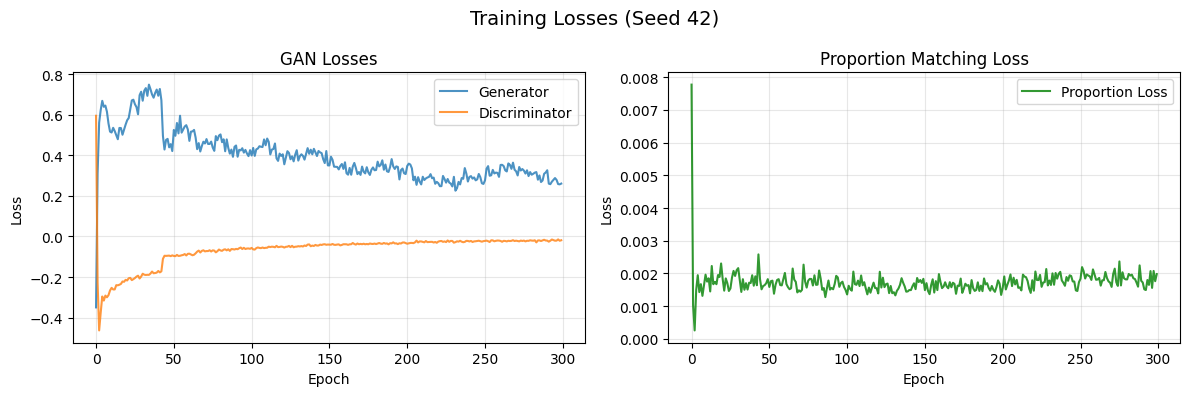

In [16]:
# Plot training losses
plot_losses(g_losses, d_losses, prop_losses,
           title=f"Training Losses (Seed {seed})",
           save_path=f"{OUTPUT_DIR}/losses_seed{seed}.png")

In [17]:
# Generate synthetic data
X_synthetic = generate_synthetic_data(generator, len(X_train), preprocessor)
y_synthetic = y_train.copy()  # Use same label distribution

print("\n=== DATA DIAGNOSTICS ===")
print(f"X_train shape: {X_train.shape}")
print(f"X_synthetic shape: {X_synthetic.shape}")
print(f"X_train range: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"X_synthetic range: [{X_synthetic.min():.4f}, {X_synthetic.max():.4f}]")


=== DATA DIAGNOSTICS ===
X_train shape: (26048, 123)
X_synthetic shape: (26048, 123)
X_train range: [-0.0000, 1.0000]
X_synthetic range: [0.0000, 1.0000]


Saved: ../outputs/gan_fixed/special_values_seed42.png


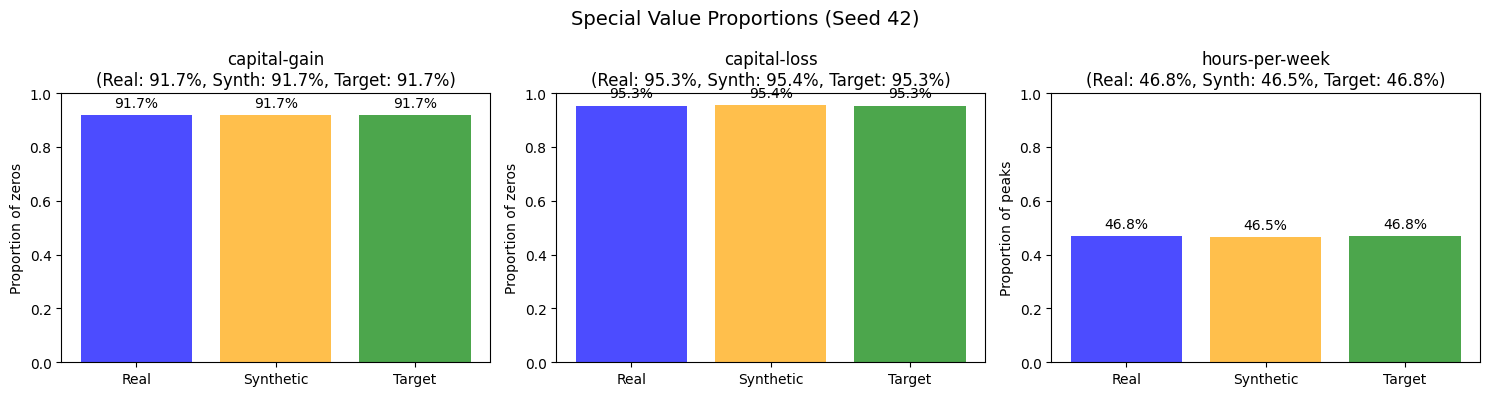

In [18]:
# Plot special value distributions (THE KEY TEST)
plot_special_values(X_train, X_synthetic, preprocessor,
                   title=f"Special Value Proportions (Seed {seed})",
                   save_path=f"{OUTPUT_DIR}/special_values_seed{seed}.png")

Saved: ../outputs/gan_fixed/distributions_seed42.png


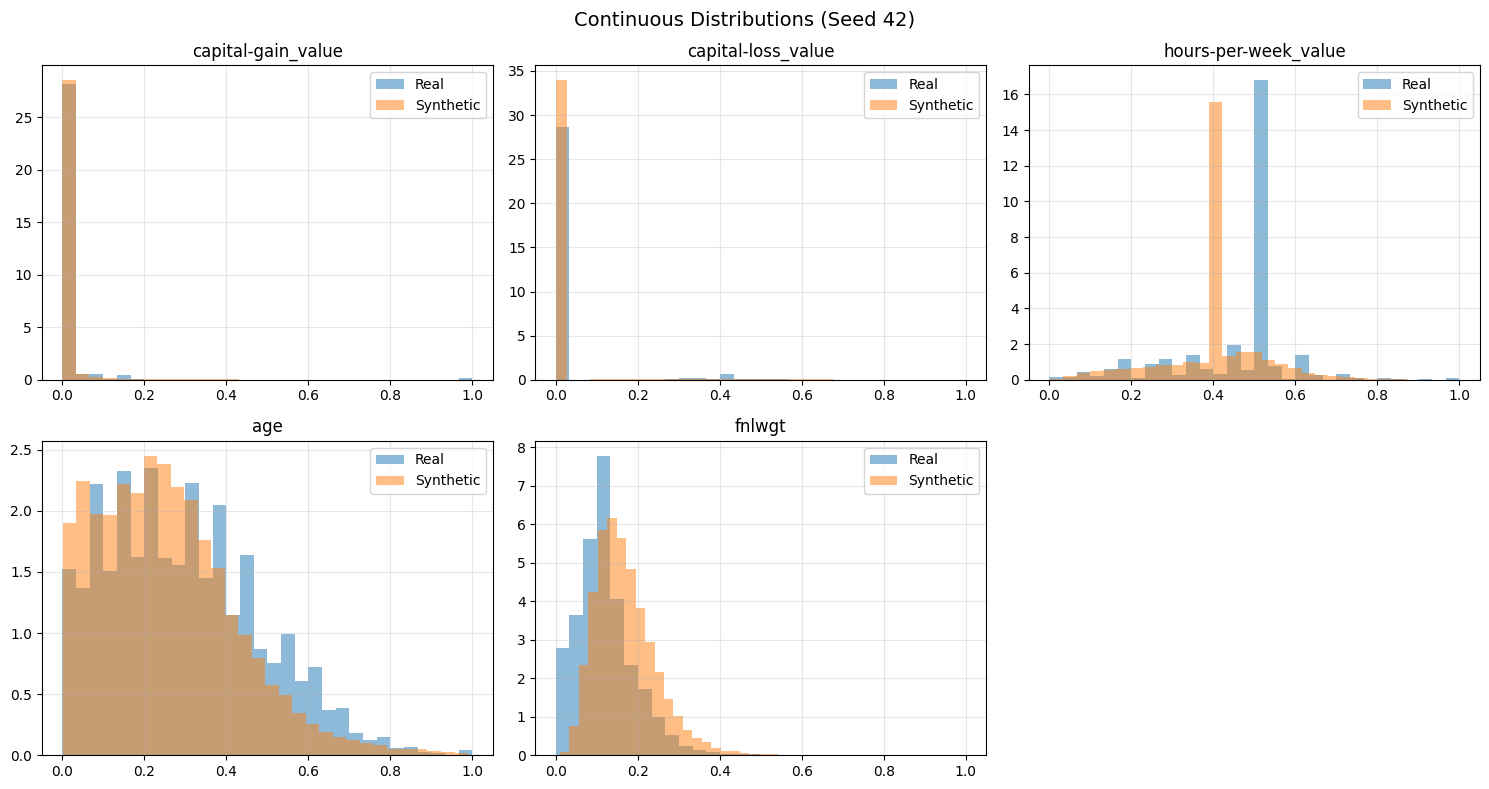

In [19]:
# Plot continuous distributions
plot_continuous_distributions(X_train, X_synthetic, preprocessor,
                             title=f"Continuous Distributions (Seed {seed})",
                             save_path=f"{OUTPUT_DIR}/distributions_seed{seed}.png")

In [20]:
# Compute metrics
print("\n=== COMPUTING METRICS ===")

det_auc, det_std = compute_detection_metric(X_train, X_synthetic, seed=seed)
efficacy, auc_real, auc_synth = compute_efficacy_metric(
    X_train, y_train, X_synthetic, y_synthetic, X_test, y_test, seed=seed
)

print(f"\n{'='*60}")
print(f"RESULTS (Seed {seed})")
print(f"{'='*60}")
print(f"Detection AUC: {det_auc:.4f} (+/- {det_std:.4f})")
print(f"  Target: < 0.70 (lower is better, 0.5 = indistinguishable)")
print(f"  Previous baseline: 0.9995")
print(f"")
print(f"Efficacy: {efficacy:.4f}")
print(f"  Target: > 0.85 (higher is better, 1.0 = same as real)")
print(f"  AUC Real: {auc_real:.4f}")
print(f"  AUC Synth: {auc_synth:.4f}")
print(f"{'='*60}")


=== COMPUTING METRICS ===

RESULTS (Seed 42)
Detection AUC: 0.9804 (+/- 0.0004)
  Target: < 0.70 (lower is better, 0.5 = indistinguishable)
  Previous baseline: 0.9995

Efficacy: 0.5395
  Target: > 0.85 (higher is better, 1.0 = same as real)
  AUC Real: 0.9065
  AUC Synth: 0.4890


## 15. Detailed Analysis

In [21]:
# Analyze what the Random Forest is using to discriminate
print("\n=== FEATURE IMPORTANCE FOR DETECTION ===")
print("(Which features make synthetic data detectable?)\n")

# Train a detector RF
y_real = np.zeros(len(X_train))
y_synth_detect = np.ones(len(X_synthetic))
X_combined = np.vstack([X_train, X_synthetic])
y_combined = np.concatenate([y_real, y_synth_detect])

rf_detector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_detector.fit(X_combined, y_combined)

# Get feature importances
importances = rf_detector.feature_importances_

# Map to feature names
feature_names = []
pos = 0
for name, ftype, dim in preprocessor.feature_info:
    if ftype == 'zero_inflated':
        feature_names.extend([f"{name}_is_zero", f"{name}_value"])
    elif ftype == 'peak_inflated':
        feature_names.extend([f"{name}_is_peak", f"{name}_value"])
    elif ftype == 'continuous':
        feature_names.append(name)
    elif ftype == 'categorical':
        feature_names.extend([f"{name}_{i}" for i in range(dim)])

# Sort by importance
sorted_idx = np.argsort(importances)[::-1]
print("Top 15 most important features for detection:")
for i in sorted_idx[:15]:
    print(f"  {feature_names[i]:30s}: {importances[i]:.4f}")


=== FEATURE IMPORTANCE FOR DETECTION ===
(Which features make synthetic data detectable?)

Top 15 most important features for detection:
  hours-per-week_value          : 0.3895
  fnlwgt                        : 0.1451
  age                           : 0.1036
  hours-per-week_is_peak        : 0.0651
  occupation_11                 : 0.0148
  occupation_3                  : 0.0135
  race_2                        : 0.0122
  capital-gain_value            : 0.0114
  race_4                        : 0.0112
  workclass_6                   : 0.0080
  relationship_3                : 0.0078
  workclass_5                   : 0.0077
  workclass_3                   : 0.0077
  occupation_0                  : 0.0072
  relationship_1                : 0.0072


In [22]:
# Compare exact proportions
print("\n=== PROPORTION COMPARISON ===")
pos = 0
for name, ftype, dim in preprocessor.feature_info:
    if ftype == 'zero_inflated':
        real_prop = X_train[:, pos].mean()
        synth_prop = X_synthetic[:, pos].mean()
        target = preprocessor.zero_proportions[name]
        diff = abs(synth_prop - target)
        print(f"{name} zeros: Real={real_prop:.3f}, Synth={synth_prop:.3f}, Target={target:.3f}, Diff={diff:.4f}")
        pos += 2
    elif ftype == 'peak_inflated':
        real_prop = X_train[:, pos].mean()
        synth_prop = X_synthetic[:, pos].mean()
        target = preprocessor.peak_proportions[name]
        diff = abs(synth_prop - target)
        print(f"{name} peaks: Real={real_prop:.3f}, Synth={synth_prop:.3f}, Target={target:.3f}, Diff={diff:.4f}")
        pos += 2
    elif ftype == 'continuous':
        pos += 1
    elif ftype == 'categorical':
        pos += dim


=== PROPORTION COMPARISON ===
capital-gain zeros: Real=0.917, Synth=0.917, Target=0.917, Diff=0.0000
capital-loss zeros: Real=0.953, Synth=0.954, Target=0.953, Diff=0.0011
hours-per-week peaks: Real=0.468, Synth=0.465, Target=0.468, Diff=0.0034


## 16. Summary

In [23]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nModel: Mixture Model GAN")
print(f"Key innovations:")
print(f"  - Zero-inflated handling for capital-gain, capital-loss")
print(f"  - Peak-inflated handling for hours-per-week")
print(f"  - education-num treated as categorical")
print(f"  - Proportion matching loss")
print(f"  - Hard sampling at generation time")
print(f"\nResults:")
print(f"  Detection AUC: {det_auc:.4f} (target: < 0.70)")
print(f"  Efficacy: {efficacy:.4f} (target: > 0.85)")
print(f"\nBaseline comparison:")
print(f"  Previous Detection AUC: 0.9995")
print(f"  Improvement: {0.9995 - det_auc:.4f}")
print("="*60)


FINAL SUMMARY

Model: Mixture Model GAN
Key innovations:
  - Zero-inflated handling for capital-gain, capital-loss
  - Peak-inflated handling for hours-per-week
  - education-num treated as categorical
  - Proportion matching loss
  - Hard sampling at generation time

Results:
  Detection AUC: 0.9804 (target: < 0.70)
  Efficacy: 0.5395 (target: > 0.85)

Baseline comparison:
  Previous Detection AUC: 0.9995
  Improvement: 0.0191
